# Loading Data

In [78]:
import numpy as np
import pandas as pd
import os
import pickle
import joblib
import sys
import glob
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from scipy.signal import correlate
import seaborn as sns
import pyod
from pyod.models.ocsvm import OCSVM
from pyod.models.lof import LOF
from pyod.models.pca import PCA
from pyod.models.iforest import IForest
from pyod.models.lmdd import LMDD
from scipy.stats import skew, kurtosis
import warnings

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [79]:
normal_path = '/net/adv_spectrum/data/rss/downsample_10/normal/871_ab'
fbs_1_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/871_ab_LOS-5M-USRP1'
fbs_2_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/871_ab_LOS-5M-USRP2'
fbs_3_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/871_ab_LOS-5M-USRP3'
fbs_4_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/871_ab_NLOS-5M-USRP1'
fbs_5_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/871_ab_Dynamics-5M-USRP1'
cso_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/871_ab_sigOver_5ms'
jamming_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/871_ab_wn'
# jamming_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/0208_anomaly'

In [80]:
def rss_power(path):
    rss = []
    for file in glob.glob(path + '/*.txt'):
        with open(file, 'r') as f:
            for line in f:
                x = line.split()
                rss.append(float(x[0]))
    return np.array(rss)

def rss_autocorr(path, step=1000):
    all_corrs = []
    for file in glob.glob(path + '/*.txt'):
        rss = []
        with open(file, 'r') as f:
            for line in f:
                x = line.split()
                rss.append(float(x[0]))
        if len(rss) < 156000:
            continue
        else:
            rss = np.array(rss).reshape(-1)[:156000]
        corrs = []
        for i in range(step, len(rss), step):
            corr = pearsonr(rss[i - step:i], rss[i:i + step])[0]
            corrs.append(corr)
        all_corrs.extend(corrs)
    return np.array(all_corrs)

In [81]:
normal_power = rss_power(normal_path)
jss_power = rss_power(jamming_path)
fbs_power = rss_power(fbs_4_path)
cso_power = rss_power(cso_path)

In [82]:
normal_corrs = rss_autocorr(normal_path)
jss_corrs = rss_autocorr(jamming_path)
fbs_corrs = rss_autocorr(fbs_4_path)
cso_corrs = rss_autocorr(cso_path)

In [83]:
X = np.concatenate((normal_power, jss_power, fbs_power, cso_power))
# X_corrs = np.concatenate((normal_corrs, jss_corrs , fbs_corrs, cso_corrs))
y = np.concatenate((['Normal']*np.shape(normal_power)[0], ['JSS']*np.shape(jss_power)[0],
                    ['FBS']*np.shape(fbs_power)[0], ['CSO']*np.shape(cso_power)[0]))
df_rss = pd.DataFrame(X, columns=['RSS'])
# df_rss['CORR'] = X_corrs
df_rss['Type'] = y

In [84]:
X_corrs = np.concatenate((normal_corrs, jss_corrs , fbs_corrs, cso_corrs))
y_corrs = np.concatenate((['Normal']*np.shape(normal_corrs)[0], ['JSS']*np.shape(jss_corrs)[0],
                    ['FBS']*np.shape(fbs_corrs)[0], ['CSO']*np.shape(cso_corrs)[0]))
df_corrs = pd.DataFrame(X_corrs, columns=['CORR'])
df_corrs['Type'] = y_corrs

In [72]:
sample = 1200
X_corrs = np.concatenate((normal_corrs[:sample], jss_corrs[:sample] , fbs_corrs[:sample], cso_corrs[:sample]))
y_corrs = np.concatenate((['Normal']*sample, ['JSS']*sample, ['FBS']*sample, ['CSO']*sample))
df_corrs = pd.DataFrame(X_corrs, columns=['CORR'])
df_corrs['Type'] = y_corrs

In [85]:
df_corrs

,CORR,Type
0,0.587246,Normal
1,0.524909,Normal
2,0.562878,Normal
3,0.578580,Normal
4,0.530185,Normal
...,...,...
28360,0.488477,CSO
28361,0.443892,CSO
28362,0.568956,CSO
28363,0.564061,CSO


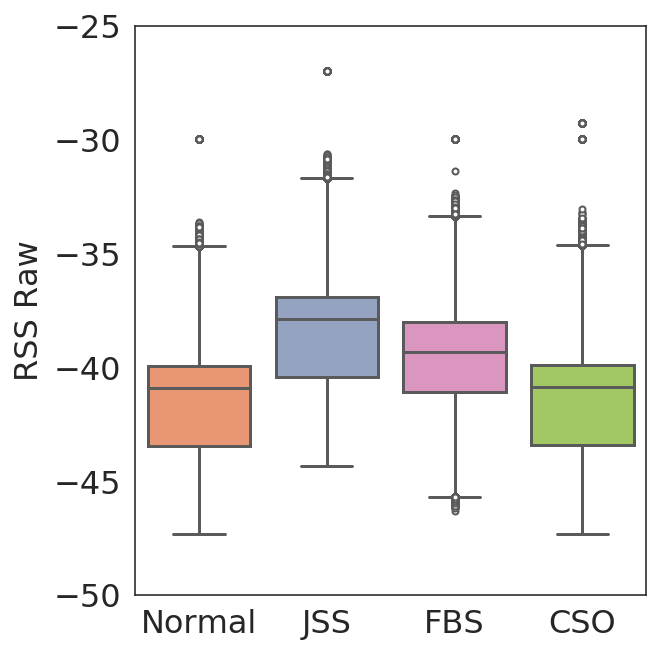

In [86]:
sns.set_style('white')
plt.rc('font', size=16)
plt.rcParams["figure.figsize"] = (5.5,5)
flierprops = dict(markerfacecolor='1.0', markersize='3',
                  linestyle='none', marker = 'o')
colorset = sns.color_palette("Set2")
colors = [colorset[i] for i in [1,2,3,4]]
ax = sns.catplot(x="Type", y="RSS", kind="box", palette = colors, 
                 data=df_rss, flierprops=flierprops);
ax.set(ylim=(-50, -25))
sns.despine(top=False, right=False)
plt.xlabel("")
plt.ylabel("RSS Raw")
plt.savefig('rss_bar.eps', bbox_inches = 'tight', format='eps')

In [88]:
df_samp = df_corrs.sample(frac = 0.1)

In [89]:
# Get names of indexes for which column Age has value 30
indexNames = df_corrs[ df_corrs['CORR'] <= 0.2 ].index
 
# Delete these row indexes from dataFrame
df_corrs.drop(indexNames , inplace=True)

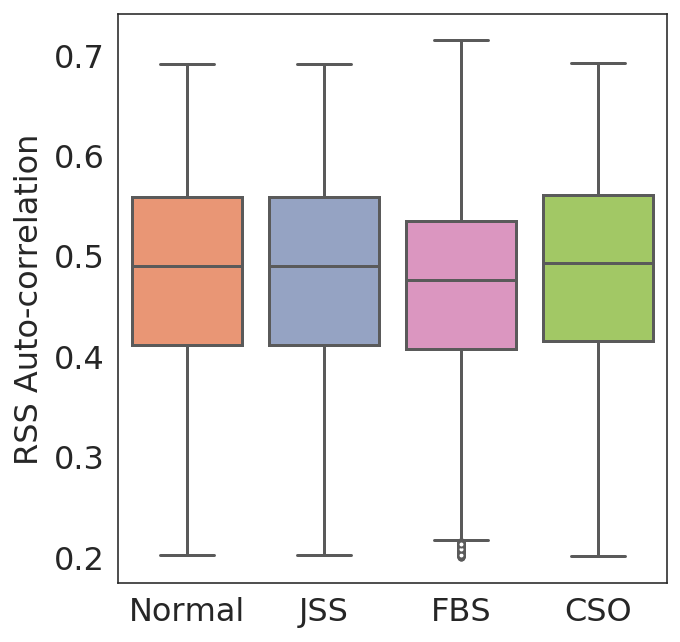

In [90]:
sns.set_style('white')
plt.rc('font', size=16)
plt.rcParams["figure.figsize"] = (5.5,5)
flierprops = dict(markerfacecolor='1.0', markersize='3',
                  linestyle='none', marker = 'o')
colorset = sns.color_palette("Set2")
colors = [colorset[i] for i in [1,2,3,4]]
ax = sns.catplot(x="Type", y="CORR", kind="box", palette = colors, 
                 data=df_corrs, flierprops=flierprops);
# ax.set(ylim=(-50, -25))
sns.despine(top=False, right=False)
plt.xlabel("")
plt.ylabel("RSS Auto-correlation")
plt.savefig('corr_bar.eps', bbox_inches = 'tight', format='eps')

# Add jamming inside

In [ ]:
def plot_single_spec(filename, title):
    time_step = 1000
    Slen = 128
#     image_num = 5
    time_duration = 10 # one image is about 1s, so # of images = time duration (s)
    start_point = 12800
    line_count = 0

    fid = open(filename + '.txt','r')
    if not os.path.exists('single_plot/' + filename + '/'):
            os.makedirs('single_plot/' + filename + '/')

    for i in range(0,start_point):
            fid.readline()
    for time in range(0,time_duration):
            fig_name = 'single_plot/' + filename + '/' + str(time+2) + '00ms.png'
#             fig,axes = plt.subplots(nrows=image_num,ncols=1,sharex=True,sharey=True)
            fig = plt.figure()
            plt.yticks([0,64,128],['0','2.5M','5M'])
            plt.xticks([0,200,400,600,800,1000], [0,51.2,102.4,153.6,204.8,256],size=14)

#             for index in range(0,image_num):
            data = []
            for i in range(0,time_step):
                    line = fid.readline()
                    line_count += 1
                    amplitude = line.split()
                    current_data = [float(i) for i in amplitude]
                    data += current_data

            data_array = np.array(data).reshape((time_step,Slen)).T
            im = plt.imshow(data_array,cmap='jet',vmin=-70,vmax=-20,aspect='auto')
            
            fig.colorbar(im)
            fig.suptitle(title,size=14)
            plt.xlabel('time(ms)')
            plt.ylabel('frequency bins')
            fig.savefig(fig_name, dpi=1200)
            plt.show()
            plt.close(fig)